In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import StructType,StructField, StringType
from pyspark.ml import image

# Setting up PySpark

In [2]:
sc = SparkContext.getOrCreate()
spark = SparkSession\
        .builder\
        .getOrCreate()

# Loading data

In [3]:
img_before_path = 'data/S1A_IW2_SLC__Intensity_IW2_VV_23Jun2018_cropped.png'
img_after_path = 'data/S1A_IW2_SLC__Intensity_IW2_VV_17Jul2018_cropped.png'

In [4]:
before_raw = spark.read.format("image").schema(image.ImageSchema.imageSchema).load(img_before_path)
after_raw = spark.read.format("image").schema(image.ImageSchema.imageSchema).load(img_after_path)

before_array = before_raw.select(col("image.data"))\
                        .rdd\
                        .flatMap(lambda f: list(f["data"]))

after_array = after_raw.select(col("image.data"))\
                        .rdd\
                        .flatMap(lambda f: list(f["data"])) 

Checking width and height of input image:

In [5]:
before_data = before_raw.select(col("image.*"))\
                  .rdd.map(lambda row: (
                    row["height"],
                    row["width"],
                    row["nChannels"],
                    list(row["data"]),
                    ))\
                  .collect()[0]

height_before = before_data[0]
width_before = before_data[1]
n_channels_before = before_data[2]

print(f'Image height: {height_before}')
print(f'Image width: {width_before}')

Image height: 1200
Image width: 2000


Creating dataframes from images and joining them into one:

In [6]:
before_df = before_array\
            .zipWithIndex()\
            .toDF()\
            .withColumnRenamed("_1", "intensity_before")\
            .withColumnRenamed("_2", "index")


after_df = after_array\
            .zipWithIndex()\
            .toDF()\
            .withColumnRenamed("_1", "intensity_after")\
            .withColumnRenamed("_2", "index")

In [7]:
both_df = before_df.join(after_df, on='index')

Creating dataframe with height and width information for every pixel:

In [8]:
both_df_hw = both_df.rdd.map(
        lambda f:
        (f['index'] % width_before, f['index'] // width_before, f['intensity_before'], f['intensity_after'] )
    )\
    .toDF()\
    .withColumnRenamed("_1", "w")\
    .withColumnRenamed("_2", "h")\
    .withColumnRenamed("_3", "intensity_before")\
    .withColumnRenamed("_4", "intensity_after")

In [9]:
both_df_hw.show()

+----+---+----------------+---------------+
|   w|  h|intensity_before|intensity_after|
+----+---+----------------+---------------+
|  26|  0|              10|             44|
|  29|  0|              35|             44|
| 474|  0|              87|             34|
| 964|  0|              25|            255|
|1677|  0|             193|             77|
|1697|  0|              17|              7|
|1806|  0|             203|             18|
|1950|  0|              36|             49|
|  40|  1|              21|             36|
| 214|  1|              64|             83|
| 250|  1|              13|             22|
| 453|  1|              65|              9|
| 509|  1|               5|              2|
| 529|  1|              63|              8|
| 927|  1|              38|            123|
|1091|  1|              39|             74|
|1506|  1|              30|             62|
|1764|  1|              32|            177|
| 590|  2|             255|             27|
| 823|  2|             151|     

# Filtering the data

Satellite images we have as an input has only one channel: intensity. Area affected by landslide has usualy high value of intensity – that's why we want to select rows (pixels), where intensity on the "after" image is high and intensity on the "before" image before is low.



In [10]:
both_df_filtered = both_df_hw\
                        .filter(col('intensity_before') < 65)\
                        .filter(col('intensity_after') > 90)

In [11]:
both_df_filtered.show()

+----+---+----------------+---------------+
|   w|  h|intensity_before|intensity_after|
+----+---+----------------+---------------+
| 964|  0|              25|            255|
| 927|  1|              38|            123|
|1764|  1|              32|            177|
|1715|  4|              22|            109|
|1945|  4|              33|            191|
|1276|  5|               2|             94|
|1745|  5|              46|            209|
|1638|  6|              11|            150|
|1322|  7|              47|            111|
| 597|  8|              20|            173|
| 742|  8|              38|            210|
|1499|  8|              42|            139|
| 628|  9|              30|            194|
| 201| 11|              16|            127|
|1479| 12|               2|            123|
| 543| 13|              32|             93|
|1255| 13|              59|            195|
|1651| 13|              50|             97|
| 428| 15|              63|            255|
| 667| 16|               7|     

In [12]:
both_df_filtered.count()

288256

As we can see, we have found ~288k pixels with that property.

# Visualization
To visualize we need to store this data in local memory. 

In [13]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.sparse import coo_matrix

In [14]:
pd_df = both_df_filtered.toPandas()

In [15]:
out_image = coo_matrix(
    (np.ones_like(list(pd_df['w'])), (list(pd_df['h']), list(pd_df['w']))),
    shape=(height_before, width_before))

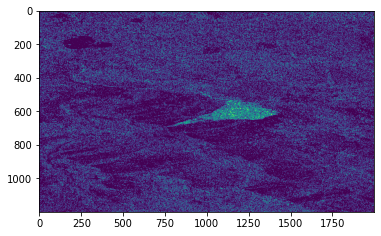

In [16]:
plt.imshow(
    out_image.toarray().astype(float)
) 

To create a mask from our visualization we can use gaussian filter:

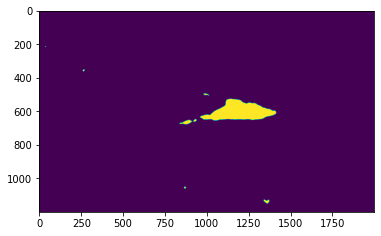

In [17]:
plt.imshow(
    gaussian_filter(out_image.toarray().astype(float), 8) > 0.25
)    